# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc'),
    'VIDEO_PATH': os.path.join('Tensorflow', 'workspace','images'),
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.0 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation|}""
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install numpy==1.23.5

In [ ]:
!pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
!pip install Pillow

In [ ]:
!pip install pyyaml

In [ ]:
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [ ]:
labels = [{'name':'number_plate', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!pip install pytz

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=.

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
INPUT_TYPE=image_tensor
PIPELINE_CONFIG_PATH=files['PIPELINE_CONFIG']
TRAINED_CKPT_PREFIX=paths['CHECKPOINT_PATH']o
EXPORT_DIR=paths['OUTPUT_PATH']

command = "python object_detection/export_inference_graph.py \
    --input_type=${INPUT_TYPE} \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_prefix=${TRAINED_CKPT_PREFIX} \
    --output_directory=${EXPORT_DIR}"
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=--checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet\export

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
MODEL_PATH  = paths['MODEL_PATH']
MODEL_SAVE_PATH = paths['TFLITE_PATH']
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH ,signature_keys=['serving_default'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()
with tf.io.gfile.GFile(MODEL_SAVE_PATH, 'wb') as f:
  f.write(tflite_model)

# 8. Load Train Model From Checkpoint

In [6]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util

In [7]:
import time
from object_detection.builders import model_builder

In [8]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [9]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-22')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## Zoom In to the Images - Want to Clear Images from the Video

In [ ]:
import cv2

In [ ]:
def zoom_at(img, zoom=1, angle=0, coord=None):
    cy, cx = [i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationaMatrix2D((cx, cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1]. flags=cv2.INTER_LINEAR)
    return result

In [ ]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'train', 'Datacluster_number_plates (1).jng')
img = cv2.imread(IMAGE_PATH)
cv2.imwrite(IMAGE_PATH, zoom_at(img, 1.5, coord=(264.5, 275)))

## 11. Detect from an Video - Create frames

In [ ]:
files_paths = {
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','images'), 
    'INPUT_PATH': os.path.join('Tensorflow', 'workspace', 'images', 'test-video'),
    'INTIAL_PATH': 'C:\\Users\\user'
}

In [ ]:
for path in files_paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [ ]:
# Importing all necessary libraries
import cv2
import os
import time

# Read the video from specified path
video_path = os.path.join(files_paths['INPUT_PATH'], 'Sample.mp4')
#cam = cv2.VideoCapture(r'C:\Users\user\Tensorflow\workspace\images\test-video\sample2.avi')
cam = cv2.VideoCapture(video_path)
ret, frame = cam.read()
length = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
print(ret)

In [ ]:
os.chdir(files_paths['OUTPUT_PATH'])

In [ ]:
os.getcwd()

In [ ]:
currentframe = 0
frame_count = length
prev_frame = None
while (True):
    ret, frame = cam.read()
    if ret:
        name = './data/frame' + str(currentframe) + '.jpg'
        print('Creating...' + name)
        if prev_frame is not None and (frame == prev_frame).all():
            print("hello")
            continue;
        cv2.imwrite(name, frame)
        currentframe += 1
        prev_frame = frame
        if(currentframe >= frame_count):
            break
    else:
        break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

In [ ]:
try:
    # creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')

    # if not created then raise error
except OSError:
    print('Error: Creating directory of data')

# frame
currentframe = 0

while (True):
    
    # reading from frame
    ret, frame = cam.read()

    if ret:
        # if video is still left continue creating images
        name = './data/frame' + str(currentframe) + '.jpg'
        print('Creating...' + name)

        # writing the extracted images
        cv2.imwrite(name, frame)
        time.sleep(1) # take schreenshot every 5 seconds

        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
    else:
        break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
vidcap = cv2.VideoCapture(video_path)
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

# 9. Detect from an Image

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [23]:
#IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'train', 'Datacluster_number_plates (1).jpg')
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'train', 'test_image.png')

In [24]:
image = cv2.imread(IMAGE_PATH)

In [25]:
import easyocr
detection_threshold = 0.7

done


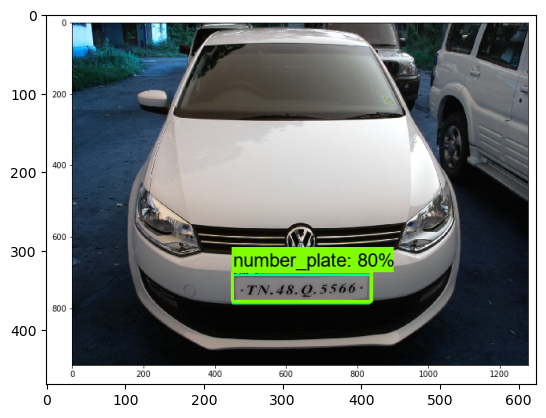

In [26]:
image_np = np.array(image)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
label_id_offset = 1
image_np_with_detections = image_np.copy()
###########
# image_p = cv2.resize(image_np_with_detections, None, fx = 2, fy = 2)
# binary = cv2.adaptiveThreshold()
# kernel = np.ones((3,3), np.unit8)
# image_np_with_detections = preprocess_image(image_np_with_detections)
#############

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)
print('done')

plt.imshow(image_np_with_detections)
plt.show()

In [37]:
image = image_np_with_detections
image = resize_with_aspect(image, 600)
image = contrast(image)
image = clean_plate(image, 600)
image = cv2.bitwise_not(image)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]
# Apply ROI filtering and OCR
ocr_result = []
for idx, box in enumerate(boxes):
    roi = box*[height, width, height, width]
#     print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)    
    print(ocr_result)
#     plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
for result in ocr_result:
    #print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1].upper())

[]


In [28]:
import cv2
import numpy as np
import sys, os
import imutils
from skimage.filters import threshold_local
from skimage import measure

In [52]:
import os
import cv2
import numpy as np
import math
import random

kNearest = cv2.ml.KNearest_create()
MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8
MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0
MIN_PIXEL_AREA = 80
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0
MAX_CHANGE_IN_AREA = 0.5
MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2
MAX_ANGLE_BETWEEN_CHARS = 12.0
MIN_NUMBER_OF_MATCHING_CHARS = 3
RESIZED_CHAR_IMAGE_WIDTH = 20
RESIZED_CHAR_IMAGE_HEIGHT = 30
MIN_CONTOUR_AREA = 100



def detectCharsInPlates(listOfPossiblePlates):
    intPlateCounter = 0
    imgContours = None
    contours = []
    if len(listOfPossiblePlates) == 0:
        return listOfPossiblePlates
    for possiblePlate in listOfPossiblePlates:
        possiblePlate.imgGrayscale, possiblePlate.imgThresh = refining.preprocess(possiblePlate.imgPlate)
        cv2.imshow("5a", possiblePlate.imgPlate)
        cv2.imshow("5b", possiblePlate.imgGrayscale)
        cv2.imshow("5c", possiblePlate.imgThresh)
        possiblePlate.imgThresh = cv2.resize(possiblePlate.imgThresh, (0, 0), fx = 1.6, fy = 1.6)
        thresholdValue, possiblePlate.imgThresh = cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        cv2.imshow("5d", possiblePlate.imgThresh)
        listOfPossibleCharsInPlate = findPossibleCharsInPlate(possiblePlate.imgGrayscale, possiblePlate.imgThresh)
        height, width, numChannels = possiblePlate.imgPlate.shape
        imgContours = np.zeros((height, width, 3), np.uint8)
        del contours[:]
        for possibleChar in listOfPossibleCharsInPlate:
            contours.append(possibleChar.contour)
        cv2.drawContours(imgContours, contours, -1, product.SCALAR_WHITE)
        cv2.imshow("6", imgContours)
        listOfListsOfMatchingCharsInPlate = findListOfListsOfMatchingChars(listOfPossibleCharsInPlate)
        imgContours = np.zeros((height, width, 3), np.uint8)
        del contours[:]
        for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
            intRandomBlue = random.randint(0, 255)
            intRandomGreen = random.randint(0, 255)
            intRandomRed = random.randint(0, 255)
            for matchingChar in listOfMatchingChars:
                contours.append(matchingChar.contour)
            cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
        cv2.imshow("7", imgContours)
        if (len(listOfListsOfMatchingCharsInPlate) == 0):
            print("chars found in plate number " + str(
                intPlateCounter) + " = (none), click on any image and press a key to continue . . .")
            intPlateCounter = intPlateCounter + 1
            cv2.destroyWindow("8")
            cv2.destroyWindow("9")
            cv2.destroyWindow("10")
            cv2.waitKey(0)
            possiblePlate.strChars = ""
            continue
        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
            listOfListsOfMatchingCharsInPlate[i].sort(key = lambda matchingChar: matchingChar.intCenterX)
            listOfListsOfMatchingCharsInPlate[i] = removeInnerOverlappingChars(listOfListsOfMatchingCharsInPlate[i])
            imgContours = np.zeros((height, width, 3), np.uint8)
            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)
                del contours[:]
                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            cv2.imshow("8", imgContours)
        intLenOfLongestListOfChars = 0
        intIndexOfLongestListOfChars = 0
        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
            if len(listOfListsOfMatchingCharsInPlate[i]) > intLenOfLongestListOfChars:
                intLenOfLongestListOfChars = len(listOfListsOfMatchingCharsInPlate[i])
                intIndexOfLongestListOfChars = i
        longestListOfMatchingCharsInPlate = listOfListsOfMatchingCharsInPlate[intIndexOfLongestListOfChars]
        imgContours = np.zeros((height, width, 3), np.uint8)
        del contours[:]
        for matchingChar in longestListOfMatchingCharsInPlate:
            contours.append(matchingChar.contour)
        cv2.drawContours(imgContours, contours, -1, product.SCALAR_WHITE)
        cv2.imshow("9", imgContours)
        possiblePlate.strChars = recognizeCharsInPlate(possiblePlate.imgThresh, longestListOfMatchingCharsInPlate)
        print("chars found in plate number " + str(
            intPlateCounter) + " = " + possiblePlate.strChars + ", click on any image and press a key to continue . . .")
        intPlateCounter = intPlateCounter + 1
        cv2.waitKey(0)
    print("\nchar detection complete, click on any image and press a key to continue . . .\n")
    cv2.waitKey(0)
    return listOfPossiblePlates
def loadKNNDataAndTrainKNN():
    allContoursWithData = []
    validContoursWithData = []
    try:
        npaClassifications = np.loadtxt("classifications.txt", np.float32)
    except:
        print("error, unable to open classifications.txt, exiting program\n")
        os.system("pause")
        return False
    try:
        npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)
    except:
        print("error, unable to open flattened_images.txt, exiting program\n")
        os.system("pause")
        return False
    npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))
    kNearest.setDefaultK(1)
    kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)
    return True

def checkIfPossibleChar(possibleChar):
    if (possibleChar.intBoundingRectArea > MIN_PIXEL_AREA and
        possibleChar.intBoundingRectWidth > MIN_PIXEL_WIDTH and possibleChar.intBoundingRectHeight > MIN_PIXEL_HEIGHT and
        MIN_ASPECT_RATIO < possibleChar.fltAspectRatio and possibleChar.fltAspectRatio < MAX_ASPECT_RATIO):
        return True
    else:
        return False
def findPossibleCharsInPlate(imgGrayscale, imgThresh):
    listOfPossibleChars = []
    contours = []
    imgThreshCopy = imgThresh.copy()
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        possibleChar = total_char.PossibleChar(contour)
        if checkIfPossibleChar(possibleChar):
            listOfPossibleChars.append(possibleChar)
    return listOfPossibleChars


def findListOfMatchingChars(possibleChar, listOfChars):
    listOfMatchingChars = []
    for possibleMatchingChar in listOfChars:
        if possibleMatchingChar == possibleChar:
            continue
        fltDistanceBetweenChars = distanceBetweenChars(possibleChar, possibleMatchingChar)
        fltAngleBetweenChars = angleBetweenChars(possibleChar, possibleMatchingChar)
        fltChangeInArea = float(abs(possibleMatchingChar.intBoundingRectArea - possibleChar.intBoundingRectArea)) / float(possibleChar.intBoundingRectArea)
        fltChangeInWidth = float(abs(possibleMatchingChar.intBoundingRectWidth - possibleChar.intBoundingRectWidth)) / float(possibleChar.intBoundingRectWidth)
        fltChangeInHeight = float(abs(possibleMatchingChar.intBoundingRectHeight - possibleChar.intBoundingRectHeight)) / float(possibleChar.intBoundingRectHeight)
        if (fltDistanceBetweenChars < (possibleChar.fltDiagonalSize * MAX_DIAG_SIZE_MULTIPLE_AWAY) and
            fltAngleBetweenChars < MAX_ANGLE_BETWEEN_CHARS and
            fltChangeInArea < MAX_CHANGE_IN_AREA and
            fltChangeInWidth < MAX_CHANGE_IN_WIDTH and
            fltChangeInHeight < MAX_CHANGE_IN_HEIGHT):
            listOfMatchingChars.append(possibleMatchingChar)
    return listOfMatchingChars
def findListOfListsOfMatchingChars(listOfPossibleChars):
    listOfListsOfMatchingChars = []
    for possibleChar in listOfPossibleChars:
        listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)
        listOfMatchingChars.append(possibleChar)
        if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:
            continue
        listOfListsOfMatchingChars.append(listOfMatchingChars)
        listOfPossibleCharsWithCurrentMatchesRemoved = []
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))
        recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(listOfPossibleCharsWithCurrentMatchesRemoved)
        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)
        break
    return listOfListsOfMatchingChars


def angleBetweenChars(firstChar, secondChar):
    fltAdj = float(abs(firstChar.intCenterX - secondChar.intCenterX))
    fltOpp = float(abs(firstChar.intCenterY - secondChar.intCenterY))
    if fltAdj != 0.0:
        fltAngleInRad = math.atan(fltOpp / fltAdj)
    else:
        fltAngleInRad = 1.5708
    fltAngleInDeg = fltAngleInRad * (180.0 / math.pi)
    return fltAngleInDeg
def distanceBetweenChars(firstChar, secondChar):
    intX = abs(firstChar.intCenterX - secondChar.intCenterX)
    intY = abs(firstChar.intCenterY - secondChar.intCenterY)
    return math.sqrt((intX ** 2) + (intY ** 2))
def recognizeCharsInPlate(imgThresh, listOfMatchingChars):
    strChars = ""
    height, width = imgThresh.shape
    imgThreshColor = np.zeros((height, width, 3), np.uint8)
    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)
    cv2.cvtColor(imgThresh, cv2.COLOR_GRAY2BGR, imgThreshColor)
    for currentChar in listOfMatchingChars:
        pt1 = (currentChar.intBoundingRectX, currentChar.intBoundingRectY)
        pt2 = ((currentChar.intBoundingRectX + currentChar.intBoundingRectWidth), (currentChar.intBoundingRectY + currentChar.intBoundingRectHeight))
        cv2.rectangle(imgThreshColor, pt1, pt2, product.SCALAR_GREEN, 2)
        imgROI = imgThresh[currentChar.intBoundingRectY : currentChar.intBoundingRectY + currentChar.intBoundingRectHeight,
                           currentChar.intBoundingRectX : currentChar.intBoundingRectX + currentChar.intBoundingRectWidth]
        imgROIResized = cv2.resize(imgROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT))
        npaROIResized = imgROIResized.reshape((1, RESIZED_CHAR_IMAGE_WIDTH * RESIZED_CHAR_IMAGE_HEIGHT))
        npaROIResized = np.float32(npaROIResized)
        retval, npaResults, neigh_resp, dists = kNearest.findNearest(npaROIResized, k = 1)
        strCurrentChar = str(chr(int(npaResults[0][0])))
        strChars = strChars + strCurrentChar
    cv2.imshow("10", imgThreshColor)
    return strChars
def removeInnerOverlappingChars(listOfMatchingChars):
    listOfMatchingCharsWithInnerCharRemoved = list(listOfMatchingChars)
    for currentChar in listOfMatchingChars:
        for otherChar in listOfMatchingChars:
            if currentChar != otherChar:
                if distanceBetweenChars(currentChar, otherChar) < (currentChar.fltDiagonalSize * MIN_DIAG_SIZE_MULTIPLE_AWAY):
                    if currentChar.intBoundingRectArea < otherChar.intBoundingRectArea:
                        if currentChar in listOfMatchingCharsWithInnerCharRemoved:
                            listOfMatchingCharsWithInnerCharRemoved.remove(currentChar)
                    else:
                        if otherChar in listOfMatchingCharsWithInnerCharRemoved:
                            listOfMatchingCharsWithInnerCharRemoved.remove(otherChar)
    return listOfMatchingCharsWithInnerCharRemoved

In [56]:
import cv2
import numpy as np
import math
import random
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5


def findPossibleCharsInScene(imgThresh):
    listOfPossibleChars = []
    intCountOfPossibleChars = 0
    imgThreshCopy = imgThresh.copy()
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    height, width = imgThresh.shape
    imgContours = np.zeros((height, width, 3), np.uint8)
    for i in range(0, len(contours)):
        cv2.drawContours(imgContours, contours, i, product.SCALAR_WHITE)
        possibleChar = total_char.PossibleChar(contours[i])
        if checkIfPossibleChar(possibleChar):
            intCountOfPossibleChars = intCountOfPossibleChars + 1
            listOfPossibleChars.append(possibleChar)  
    print("\nstep 2 - len(contours) = " + str(len(contours)))
    print("step 2 - intCountOfPossibleChars = " + str(intCountOfPossibleChars))
    cv2.imshow("2a", imgContours)
    return listOfPossibleChars

def extractPlate(imgOriginal, listOfMatchingChars):
    possiblePlate = total_plate.PossiblePlate()
    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)
    fltPlateCenterX = (listOfMatchingChars[0].intCenterX + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterX) / 2.0
    fltPlateCenterY = (listOfMatchingChars[0].intCenterY + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY) / 2.0
    ptPlateCenter = fltPlateCenterX, fltPlateCenterY
    intPlateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectX + listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectWidth - listOfMatchingChars[0].intBoundingRectX) * PLATE_WIDTH_PADDING_FACTOR)
    intTotalOfCharHeights = 0
    for matchingChar in listOfMatchingChars:
        intTotalOfCharHeights = intTotalOfCharHeights + matchingChar.intBoundingRectHeight
    fltAverageCharHeight = intTotalOfCharHeights / len(listOfMatchingChars)
    intPlateHeight = int(fltAverageCharHeight * PLATE_HEIGHT_PADDING_FACTOR)
    fltOpposite = listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY - listOfMatchingChars[0].intCenterY
    fltHypotenuse = distanceBetweenChars(listOfMatchingChars[0], listOfMatchingChars[len(listOfMatchingChars) - 1])
    fltCorrectionAngleInRad = math.asin(fltOpposite / fltHypotenuse)
    fltCorrectionAngleInDeg = fltCorrectionAngleInRad * (180.0 / math.pi)
    possiblePlate.rrLocationOfPlateInScene = ( tuple(ptPlateCenter), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg )
    rotationMatrix = cv2.getRotationMatrix2D(tuple(ptPlateCenter), fltCorrectionAngleInDeg, 1.0)
    height, width, numChannels = imgOriginal.shape
    imgRotated = cv2.warpAffine(imgOriginal, rotationMatrix, (width, height))
    imgCropped = cv2.getRectSubPix(imgRotated, (intPlateWidth, intPlateHeight), tuple(ptPlateCenter))
    possiblePlate.imgPlate = imgCropped
    return possiblePlate

def detectPlatesInScene(imgOriginalScene):
    listOfPossiblePlates = []
    height, width, numChannels = imgOriginalScene.shape
    imgGrayscaleScene = np.zeros((height, width, 1), np.uint8)
    imgThreshScene = np.zeros((height, width, 1), np.uint8)
    imgContours = np.zeros((height, width, 3), np.uint8)
    cv2.destroyAllWindows()
    cv2.imshow("0", imgOriginalScene)
    imgGrayscaleScene, imgThreshScene = refining.preprocess(imgOriginalScene)
    cv2.imshow("1a", imgGrayscaleScene)
    cv2.imshow("1b", imgThreshScene)
    listOfPossibleCharsInScene = findPossibleCharsInScene(imgThreshScene)
    print("step 2 - len(listOfPossibleCharsInScene) = " + str(len(listOfPossibleCharsInScene)))
    imgContours = np.zeros((height, width, 3), np.uint8)
    contours = []
    for possibleChar in listOfPossibleCharsInScene:
        contours.append(possibleChar.contour)
    cv2.drawContours(imgContours, contours, -1, product.SCALAR_WHITE)
    cv2.imshow("2b", imgContours)
    listOfListsOfMatchingCharsInScene = findListOfListsOfMatchingChars(listOfPossibleCharsInScene)
    print("step 3 - listOfListsOfMatchingCharsInScene.Count = " + str(len(listOfListsOfMatchingCharsInScene)))
    imgContours = np.zeros((height, width, 3), np.uint8)
    for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
        intRandomBlue = random.randint(0, 255)
        intRandomGreen = random.randint(0, 255)
        intRandomRed = random.randint(0, 255)
        contours = []
        for matchingChar in listOfMatchingChars:
            contours.append(matchingChar.contour)
        cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
    cv2.imshow("3", imgContours)
    for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
        possiblePlate = extractPlate(imgOriginalScene, listOfMatchingChars)
        if possiblePlate.imgPlate is not None:
            listOfPossiblePlates.append(possiblePlate)
    print("\n" + str(len(listOfPossiblePlates)) + " possible plates found")  # 13 with MCLRNF1 image
    print("\n")
    cv2.imshow("4a", imgContours)
    for i in range(0, len(listOfPossiblePlates)):
        p2fRectPoints = cv2.boxPoints(listOfPossiblePlates[i].rrLocationOfPlateInScene)
        cv2.line(imgContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), product.SCALAR_RED, 2)
        cv2.line(imgContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), product.SCALAR_RED, 2)
        cv2.line(imgContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), product.SCALAR_RED, 2)
        cv2.line(imgContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), product.SCALAR_RED, 2)
        cv2.imshow("4a", imgContours)
        print("possible plate " + str(i) + ", click on any image and press a key to continue . . .")
        cv2.imshow("4b", listOfPossiblePlates[i].imgPlate)
        cv2.waitKey(0)
    print("\nplate detection complete, click on any image and press a key to begin char recognition . . .\n")
    cv2.waitKey(0)
    return listOfPossiblePlates

In [57]:
detectPlatesInScene(image_np_with_detections)

NameError: name 'refining' is not defined

In [40]:
def contrast(img: np.ndarray) -> np.ndarray:
    """Improves contrast to deal with blurry images

    Args:
        img (np.ndarray): Image

    Returns:
        img2 (np.ndarray): high-contrast image
    """
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe=cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    lab=cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l,a,b=cv2.split(lab)  # split on 3 different channels

    l2=clahe.apply(l)  # apply CLAHE to the L-channel

    lab=cv2.merge((l2,a,b))  # merge channels
    img2=cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
    return img2

def resize_with_aspect(image: np.ndarray, width: int = 500) -> np.ndarray:
    """Resize the image while preserving the aspect ratio

    Args:
        image (np.ndarray): Image to be resized
        width (int, optional): Width to be resized to. Defaults to 500.

    Returns:
        np.ndarray: Resized Image
    """
    height = int(width/image.shape[1] * image.shape[0])
    return cv2.resize(image, (width, height))

def clean_plate(cvImage: np.ndarray, fixed_width: int) -> np.ndarray:
    """
    Extract Value channel from the HSV format of image and apply adaptive thresholding
    to reveal the characters on the license plate.
    """
    plate_img = cvImage.copy()
    V = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2]

    T = threshold_local(V, 29, offset=15, method='gaussian')

    thresh = (V > T).astype('uint8') * 255

    thresh = cv2.bitwise_not(thresh)

    """At this point, we tried applying the tried and tested method of opening
    and closing the image using erosion and dilation, which usually works well for removing noise.
    However, in this case, it was also separating characters like 'N', which a thinner connection
    between the 2 vertical lines. Thus, removing noise like this became a risk which would not pay off.
    We found segmenting the characters based on size to be a better approach than this, but this could
    be feasible if the letters and numbers were clear in all the images."""

    plate_img = imutils.resize(plate_img, width=fixed_width)
    thresh = imutils.resize(thresh, width=fixed_width)
    # Makes the letters slightly thicker
    kernel = np.ones((3, 3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    return thresh

def perform_segmentation(image: np.ndarray):
    """Performs Segmentation

    Args:
        image (np.ndarray): Image to be segmented

    Returns:
        list(np.ndarray): List of segmented images
    """
    # Resizes the image, keeping the width fixed at 500
    image = resize_with_aspect(image, 500)

    # Increases contrast of the image using the CLAHE technique
    image = contrast(image)

    # Removes noise from coloured images
    
    # cv2.imshow("image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


    """For PS1, we found out the skew angle by drawing a slanted rectangle as a bounding box,
    around the largest detected contour of the image.
    This approach fails for number plate detection as we are unable to draw the bounding rectangle
    around the text due to the presence of the number plate itself."""
    # angle = getSkewAngle(image)
    # new_img = rotateImage(image, -1.0 * angle)
    # new_img = resize_with_aspect(new_img, 500)


    new_img = image


    iwl_bb = clean_plate(new_img, 500)
    iwl_wb = cv2.bitwise_not(iwl_bb)
    # cv2.imshow("iwl_bb", iwl_bb)
    # cv2.imshow("iwl_wb", iwl_wb)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


    # Total area of the resized image.
    img_area = iwl_bb.shape[1] * iwl_bb.shape[0]


    """Here we had the option of using RETR_EXTERNAL (or) RETR_TREE"""
    _, contours,_=cv2.findContours(iwl_bb,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    rectangles=[]

    """We have only selected contours that are of a size bigger that 1/200th Area of the image,
    or are not bigger than half the image size.
    A further classification of height not less that 1/5th of the image height, and
    width not more than 1/5th of the image width was also added to remove the inherent noise
    in the given number plate."""
    for cnt in contours:
        if cv2.contourArea(cnt) > img_area / 2:
            continue
        if cv2.contourArea(cnt) > img_area / 200:
            x,y,w,h=cv2.boundingRect(cnt)
            if(h < (iwl_bb.shape[0] / 5) or w > (iwl_bb.shape[1] / 5)):
                continue
            rectangles.append([x,y,w,h])

    "Removing cases where a contour is inside another contour like in 'O' and 'D'"
    final_rect = []
    for (x, y, w, h) in rectangles:
        flag = True
        for(x2, y2, w2, h2) in rectangles:
            if x > x2 and y > y2 and x + w < x2 + w2 and y + h < y2 + h2:
                flag = False
                break
        if flag:
            final_rect.append([x,y,w,h])

    rectangles = final_rect


    rectangles.sort()
    print("Number of characters recognized:", len(rectangles))
    

    images = []

    """This part segments each image from the number plate based on the rectangle 
    coordinates received previously."""
    for i in range(len(rectangles)):
        cv2.rectangle(iwl_wb,
            (rectangles[i][0],rectangles[i][1]),
            (rectangles[i][0]+rectangles[i][2],
            rectangles[i][1]+rectangles[i][3]),
            (0,255,0),
            3
        )
        image=iwl_bb[
            rectangles[i][1] : rectangles[i][1] + rectangles[i][3],
            rectangles[i][0] : rectangles[i][0] + rectangles[i][2]
        ]
        larger = max(image.shape[0], image.shape[1])
        smaller = min(image.shape[0], image.shape[1])
        border=int(0.2 * larger)
        # Adds a border around the cropped image.
        image = cv2.copyMakeBorder(
            image,
            top = (larger - smaller) // 2 + border,
            bottom = (larger - smaller) // 2 + int( 1 * border),
            left = border,
            right = int(1 * border),
            borderType = cv2.BORDER_CONSTANT,
            value = [0, 0, 0])
        
        # cv2.namedWindow("img_{}".format(i), cv2.WINDOW_GUI_EXPANDED)
        cv2.imshow("img_{}".format(i), image)
        images.append(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return images

In [32]:
perform_segmentation(image)

Number of characters recognized: 1


KeyboardInterrupt: 

In [ ]:
import cv2
# Function to preprocess the image
def preprocess_image(image):
    # Resize the image to a fixed size for consistent character recognition
    print(image.shape)
    image = cv2.resize(image, (800, 600))  # Adjust the dimensions as needed
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding to binarize the image
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # Sharpen the image to enhance character edges
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    sharpened = cv2.filter2D(thresholded, -1, kernel)
    
    color_image = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)
    return color_image

def sharpen_image(image):
    # Create a sharpening kernel
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    
    # Apply the kernel to the image
    sharpened = cv2.filter2D(image, -1, kernel)
    
    return sharpened

def resize_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (600, 800))
    _, result = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)
    adaptive_threshold = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 5)
    adaptive_threshold = cv2.cvtColor(adaptive_threshold, cv2.COLOR_GRAY2BGR)
    return adaptive_threshold

def preprocess_roi(image):
    roi = cv2.resize(roi, (800, 600))
    gray_roi = cv2.cvtColor(roi, cvt.cvtColo)
                       
plt.imshow(resize_image(image))
plt.show()
plt.imshow(image)
plt.show()

In [ ]:
image = cv2.imread(IMAGE_PATH)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use adaptive thresholding to binarize the image
binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Invert the binary image
binary = cv2.bitwise_not(binary)

# Dilate the image to connect broken characters
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(binary, kernel, iterations=1)

# Find contours in the dilated image
_, contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and extract regions with potential text
roi_candidates = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if 100 < w < 500 and 10 < h < 100:
        roi_candidates.append((x, y, w, h))

# Sort the candidates by X-coordinate
roi_candidates.sort(key=lambda x: x[0])

# # Extract and recognize text from ROIs
# import pytesseract

# for (x, y, w, h) in roi_candidates:
#     roi = binary[y:y + h, x:x + w]
#     text = pytesseract.image_to_string(roi, config='--psm 6')  # --psm 6 for treating the image as a single text line
#     print(f"Detected Text: {text}")

plt.imshow(binary)
plt.show()

In [ ]:
from PIL import Image
Image.ANTIALIAS

# Enhancement of Image

In [ ]:
# Apply Gaussian blur to reduce noise
image = cv2.imread('CarSample9.png')
#print(img) or print(img.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# Apply morphological operations to clean the image
kernel = np.ones((3, 3), np.uint8)
morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

license_plate = None
# Find contours in the image
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
print(contours)
# Filter and extract the potential license plate contour
for contour in contours:
    if cv2.contourArea(contour) > 0 and cv2.contourArea(contour) < 30000:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        license_plate = image[y:y + h, x:x + w] 
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Save the enhanced image
# print(license_plate)
# plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
# plt.show()
# if(license_plate != None): 
cv2.imwrite('CarSample10.png', license_plate)
cv2.imshow('Enhanced License Plate', license_plate)
cv2.waitKey(0)
cv2.destroyAllWindows()

##High Accuracy-> OpenALR(OPTION) - Paid

## Validation of an license plate / cleaning

In [ ]:
import re

def validate_vehicle_registration(registration_number):
    # Define a regular expression pattern for the vehicle registration format without spaces
    pattern = r'^[A-Z]{2}\d{1,2}[A-HJ-NP-Z0-9]{0,3}\d{1,4}$'
    
    # Define a list of valid state codes
    valid_state_codes = ["AP", "AR", "AS", "BR", "CG", "GA", "GJ", "HR", "HP", "JH", "KA", "KL", "MP", "MH", "MN", "ML", "MZ", "NL", "OR", "PB", "RJ", "SK", "TN", "TR", "UP", "UK", "WB", "AN", "CH", "DN", "DD", "DL", "JK", "LA", "LD", "PY"]
    
    # Use re.match to check if the input matches the pattern
    if re.match(pattern, registration_number):
        state_code = registration_number[:2]
        if state_code in valid_state_codes:
            return True
    return False


# Test with the provided valid registration numbers
valid_registration_numbers = ["DL 1CS 2797", "HR 81B 2177"]

for registration_number in valid_registration_numbers:
    if validate_vehicle_registration(registration_number):
        print(f'{registration_number} is a valid registration number.')
    else:
        print(f'{registration_number} is not a valid registration number.')


def validate_license_plate(license_plate):
    # Define a regular expression pattern based on the provided rules
    pattern = r'^[A-Z]{2}-\d{2}-[A-NP-Z]{1,3}-\d{1,4}$'
    
    # Check if the provided license plate matches the pattern
    if re.match(pattern, license_plate):
        return "Valid License Plate"
    else:
        return "Invalid License Plate"

# Test with some license plate examples
print(validate_vehicle_registration("22BH6517A"))  # Should print "Valid License Plate"
#print(validate_license_plate("XY-34-ZW-5678"))  # Should print "Invalid License Plate"



def clean_license_plate_text(ocr_text):
    # Define a regular expression pattern to remove special characters
    cleaned_text = re.sub(r'[^A-Za-z0-9\- ]', '', ocr_text)
    
    return cleaned_text

# Example usage:
detected_text = "1CS-2737,"
cleaned_text = clean_license_plate_text(detected_text)
validate = validate_license_plate(cleaned_text)

print(f"Original Text: {detected_text}")
print(f"Cleaned Text: {cleaned_text}")


## 10. Detection from Video

In [ ]:
import easyocr
from os import listdir

folderdir = os.path.join(paths['IMAGE_PATH'], 'sample-video')
detection_threshold = 0.8
filename = 'detection_results_2.csv'
writeheader(filename, 'Detection_Images')
index = 0
for images in os.listdir(folderdir):
    if(images.endswith('.jpg')):
        IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'sample-video',  images)
        img = cv2.imread(IMAGE_PATH)
        image_np = np.array(img)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=5,
                    min_score_thresh=.8,
                    agnostic_mode=False)
#         print('done')

#         plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
#         plt.show()
        image = image_np_with_detections
        scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
        boxes = detections['detection_boxes'][:len(scores)]
        classes = detections['detection_classes'][:len(scores)]
        width = image.shape[1]
        height = image.shape[0]
        
        # Apply ROI filtering and OCR
        for idx, box in enumerate(boxes):
#             print(box)
            roi = box*[height, width, height, width]
#             print(roi)
            region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
            reader = easyocr.Reader(['en'])
            ocr_result = reader.readtext(region)
#             print(ocr_result)
            plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
            text = ""
            for result in ocr_result:
                np.sum(np.subtract(result[0][2],result[0][1]))
                text += result[1].upper() + ''
            cleaned_text = clean_license_plate_text(text)
            print(cleaned_text)
            save_results(index, cleaned_text, region, filename, 'Detection_Images')
            index += 1
            if(ocr_result):
                plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
                plt.show()


In [ ]:
results

In [ ]:
detections.keys()

In [ ]:
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))

# Apply OCR to Detection

In [ ]:
!pip install easyocr

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
import easyocr

In [ ]:
detection_threshold = 0.7

In [ ]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [ ]:
width = image.shape[1]
height = image.shape[0]

In [ ]:
from torch import mps

In [ ]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [ ]:
text = ""
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])
    text += result[1].upper() + " "
    
print(text)

# OCR Filtering

In [ ]:
region_threshold = 0.05

In [ ]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [ ]:
text = filter_text(region, ocr_result, region_threshold)
text

# Bring it Together

In [ ]:
plt.imshow(image_np_with_detections)

In [ ]:
region_threshold = 0.6

In [ ]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

In [ ]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Save Results

In [ ]:
import csv
import uuid
import datetime

In [ ]:
def save_results(id, text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
     
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([id, img_name, text, timestamp])

def writeheader(csv_file, folder_path):
    # Check if the CSV file already exists
    header = ["ID", "IMAGE_NAME", "LICENSE_PLATE_NUMBER", "DETECTED_AT"]
    csv_exists = False
    try:
        with open(csv_file, 'r', newline='') as file:
            reader = csv.reader(file)
            existing_header = next(reader, [])
            if existing_header == header:
                csv_exists = True
    except FileNotFoundError:
        pass

    # If the CSV file doesn't exist or has a different header, create a new file with the header
    if not csv_exists:
        with open(csv_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(header)

In [ ]:
save_results(0, text, region, 'detection_results.csv', 'Detection_Images')

In [ ]:
writeheader('detection_results.csv', 'Detection_Images')

## Download the model

In [ ]:
import joblib 

In [ ]:
filename = 'detection_model.pkl'

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
import cv2

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [19]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [20]:
import os

In [21]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [22]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [23]:
!{command}

2023-10-20 21:57:23.571016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 21:57:40.137101: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 21:57:40.180681: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 21:57:58.410415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-10-20 21:57:58.411199: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
!pip install jaxlib==0.4.18 --upgrade

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
!pip uninstall tensorflowjs -y
!pip install tensorflowjs

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [7]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [8]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [9]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [10]:
!{command}

2023-10-20 22:36:23.890630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 22:36:23.890975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-20 22:36:37.413058: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 22:36:37.451592: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 22:36:48.994669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-10-20 22:36:48.995036: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed c

In [11]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'license_detect.tflite')

In [12]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [13]:
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\license_detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [14]:
!{command}

Estimated count of arithmetic ops: 1.698 G  ops, equivalently 0.849 G  MACs


2023-10-20 22:38:31.221703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 22:38:31.221796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-20 22:38:39.502790: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 22:38:39.517215: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-10-20 22:38:46.459402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2023-10-20 22:38:46.459495: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed c

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##